# Análise de Sentimento e Classificação de Temas

**Resumo dos passos**

- **Extração e Tratamentos de Texto**
    - Extração de 15 mil comentários por empresa na Play Store
    - Função de tratamento de texto: tradução de emojis, remoção de stopwords, lemmentização e etc
- **Análise de Sentimentos e Emoções**
    - Verifiicação do período de comentários para cada empresa
    - Aplicação da função com os modelos de sentimento e emoção do Pysentimiento
    - Análise por agrupamento por notas (não é tão eficiente)
    - Análise por agrupamento por versão (não é tão eficiente)
    - Análise por sentimento: visão geral, reclassificação para sentimento menos ou mais forte e sentimentos neutros para positivos e negativos
    - Análise por emoção: aplicação da função de emoções em grandes sentimentos e visão geral
- **Classificação de Temas**
    - Criação manual dos temas e aplicação da função de classificação de temas
    - Geração do sentimento médio por tema e visão em gráfico de dispersão
    - Análise em amostra de comentários positivos e negativos
- **Passos Pensados, mas não eficientes**
    - Tratamento de abreviações e gírias seria algo muito complexo
    - Aplicação da análise de ironia, classificou quase todos comentários como ironicos
    - A classificação de temas para sentimento não fez tanto sentido por conta de estarmos usando o sentimento médio por tema (neg, neu, pos)
    - Gráficos de wordcloud não foram eficiente para identificar os principais assuntos por temas
- **Etapas Futuras**
    - Reaplicar a análise futuramente para entender a evolução dos sentimentos

In [1]:
#Para realizar paralelismo
import swifter

#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

c:\Users\Computador\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-10 16:24:06 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:06 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-10 16:24:07 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-10 16:24:10 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-10 16:24:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-10 16:24:10 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:11 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package         |
-------------------------------
|

## Funções 
**tratamento_de_texto**: Funciona para realizar limpezas com o nome da operados para o termo "operados", porque a Claro e a Vivo podem ter algum tipo de conotação específica se interpretadas pelo modelo sentimento, transformação dos emojis para formatos textuais e qualquer coisa relacionadas a possíveis links nos comentaráios. Além da lemmatização dos comentários para um formato mais geral das palavras. 

**classificar_tema**: Após testar alguns modelos de classificação de tópicos, optei por fazer a classificação manual dos temas mais falados com uma lista de termos agrupados em grandes temas gerais que ocorrem com esse setor.

**analisar_sentimento_todos**: O Pysentimiento possui 4 funções de análise de sentimento, optei de realizar a análise sentimento e emoção. Para as emoções, que são gerados diversas emoções em inglês, optei por agrupar em 8 grandes emoções para melhorar a análise.

In [18]:
stopwords_pt = set(stopwords.words("portuguese"))

In [19]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'\b(vivo|claro|tim)\b', 'operadora', texto)
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zá-úà-üç\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [35]:
temas_manuais = {
    "Operadora": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atendimento": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"não responde", r"reclame"],
    "Usabilidade": [r"interface", r"usabilidade", r"navegação", r"botão", r"menu", r"layout", r"tela", r"confuso", r"difícil"],
    "Conta": [r"fatura", r"boleto", r"cobrança", r"pagamento", r"conta", r"valor indevido", r"preço errado"],
    "Plano": [r"serviço", r"plano", r"contrato", r"assinatura", r"benefício", r"pacote", r"promoção", r"desconto", r"benefício", r"cashback", r"oferta"],
    "Internet": [r"internet", r"sinal", r"conexão", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda", r"recarga", r"créditos", r"saldo"],
    "Desempenho": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade", r"atualização", r"atualizei", r"versão", r"nova versão", r"última atualização"],
    "Notificações": [r"notificação", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}

In [57]:
temas_manuais_abrevidado = {
    "Op.": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atend.": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"não responde", r"reclame"],
    "Usab.": [r"interface", r"usabilidade", r"navegação", r"botão", r"menu", r"layout", r"tela", r"confuso", r"difícil"],
    "Conta": [r"fatura", r"boleto", r"cobrança", r"pagamento", r"conta", r"valor indevido", r"preço errado"],
    "Plano": [r"serviço", r"plano", r"contrato", r"assinatura", r"benefício", r"pacote", r"promoção", r"desconto", r"benefício", r"cashback", r"oferta"],
    "Net": [r"internet", r"sinal", r"conexão", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda", r"recarga", r"créditos", r"saldo"],
    "Desemp.": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade", r"atualização", r"atualizei", r"versão", r"nova versão", r"última atualização"],
    "Not.": [r"notificação", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}

In [37]:
def classificar_tema(texto, temas_dict):
    texto = texto.lower()
    temas_encontrados = []
    for tema, padroes in temas_dict.items():
        for padrao in padroes:
            if re.search(padrao, texto):
                temas_encontrados.append(tema)
                break  # Evita múltiplas adições do mesmo tema
    return temas_encontrados  # Sem categoria 'Outro'

In [22]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


---
# Extração de Comentários
Aproveitando um script feito em outro [notebook]('https://github.com/PedroReste/data_eng_insights/tree/main/web_scraping_comentarios_apps), será coletado aproximadamente 15 mil comentários de cada aplicativo na Play Store pela consistência dos dados em relação ao iOS. Além do caso brasileiro de exister, de forma majoritária, mais usuários de Android do que iOS.

In [ ]:
qtd_comentarios = 15000

dados_android = []

apps = {
    "Claro": "com.nvt.cs",
    "TIM": "br.com.timbrasil.meutim",
    "Vivo": "br.com.vivo"
}

In [24]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [25]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])
comentarios_android.to_csv("comentarios.csv", index=False)
comentarios_android.shape

(45000, 5)

---
# Análise de Sentimento
Nessa seção será aplicado os tratamentos necessários aos comentários extraídos da Play Store, aplicação dos modelos do Pysentimiento para entender os sentimentos e emoções do comentários e uma análise encima das informações extraidas da store e da aplicação dos modelos.

**Insights**
- O período dos comentários dos apps é próximo, estando entre 10/dez/2024 e 09/jun/2025, com 15 mil comentários cada. Exceto a Vivo, que o perído é entre 13/abr/2025 e 09/jun/2025.

- Notas
    - Observando o geral das notas dos comentários do período, para todos os apps, se destaca a quantidade de avaliações máximas.
    - Exceto a TIM, que também tem muitas avaliações máximas, as avaliações de 1, são maiores.
    - Observando as notas dos comentários ao decorrer dos meses, o comportamento do geral se mantém para os meses também.
    - Não fez tanto sentido tentar verificar a nota média por versão do app que usuários tinham quando comentaram.
- Sentimentos por Versão
    - Os apps lançam muitas versão intermediárias, que dificutam uma análise mais aprofundada a partir dos comentários. Nesse caso, não foi tão relevante assim.
- Sentimentos 
    - Em um primeiro momento, encontrei diversos comentários compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos.
    - Estabelecendo um limite probabildiade, comentários neutros acima 70% de serem neutros se matiam e abaixos, eram reclassificados como positivos ou negativos.
    - Com a reclassificação geral, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.
    - Detalhando os sentimentos negativos e positivos entre muito ou moderado, utilizando a mesma regra de 70% de probabilidade. A Vivo e Claro, possuem um comportamento muito semelhante.
    - No caso de TIM, se mantem distoante, com comentários muito negativos na maioria.
    - Nas emoções gerais, Vivo e Claro seguem um comportamento parecido, tendo como principal emoção a **alegria**, em seguida da **neutralidade**. Enquanto as demais emoções não possuem expressividade.
    - A TIM distoa, tendo como principal emoção a **netrualidade**, seguido de **alegria** e **raiva**, refletindo o sentimento geral dos comentários.

### Informações Gerais

In [26]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|██████████| 45000/45000 [1:12:54<00:00, 10.29it/s]


In [27]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 45000/45000 [51:36<00:00, 14.53it/s]  


In [102]:
print("Data mínima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data mínima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data mínima da Vivo: ", df[df['app']=='Vivo']['date'].min())
print("Data máxima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data máxima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data máxima da Vivo: ", df[df['app']=='Vivo']['date'].max())

Data mínima da Claro:  2024-12-11 11:32:18
Data mínima da TIM:  2024-12-12 11:37:05
Data mínima da Vivo:  2025-04-13 12:18:16
Data máxima da Claro:  2025-06-09 16:14:31
Data máxima da TIM:  2025-06-09 16:05:37
Data máxima da Vivo:  2025-06-09 16:22:06


In [ ]:
#Sentimento Geral do App
df_explodido = df.explode('app')

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

df_tema = df_explodido.groupby('app').agg(
    volume=('app', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

df_tema

,app,volume,sentimento_medio
0,Claro,15000,0.268696
1,TIM,15000,-0.223043
2,Vivo,15000,0.229890


### Notas
- Observando o geral das notas dos comentários do período, para todos os apps, se destaca a quantidade de avaliações máximas.
- Exceto a TIM, que também tem muitas avaliações máximas, as avaliações de 1, são maiores.
- Observando as notas dos comentários ao decorrer dos meses, o comportamento do geral se mantém para os meses também.
- Não fez tanto sentido tentar verificar a nota média por versão do app que usuários tinham quando comentaram.

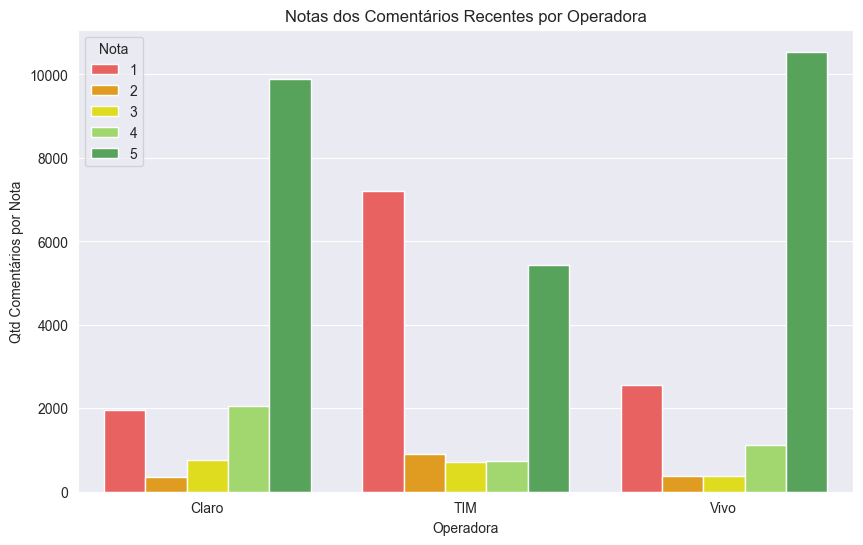

In [30]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plotar gráfico com hue simplificado
sns.countplot(
    data=df,
    x='app',
    hue='score',
    palette={1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'},
    hue_order=[1, 2, 3, 4, 5]
)

plt.title("Notas dos Comentários Recentes por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Qtd Comentários por Nota")
plt.legend(title="Nota")

plt.show()

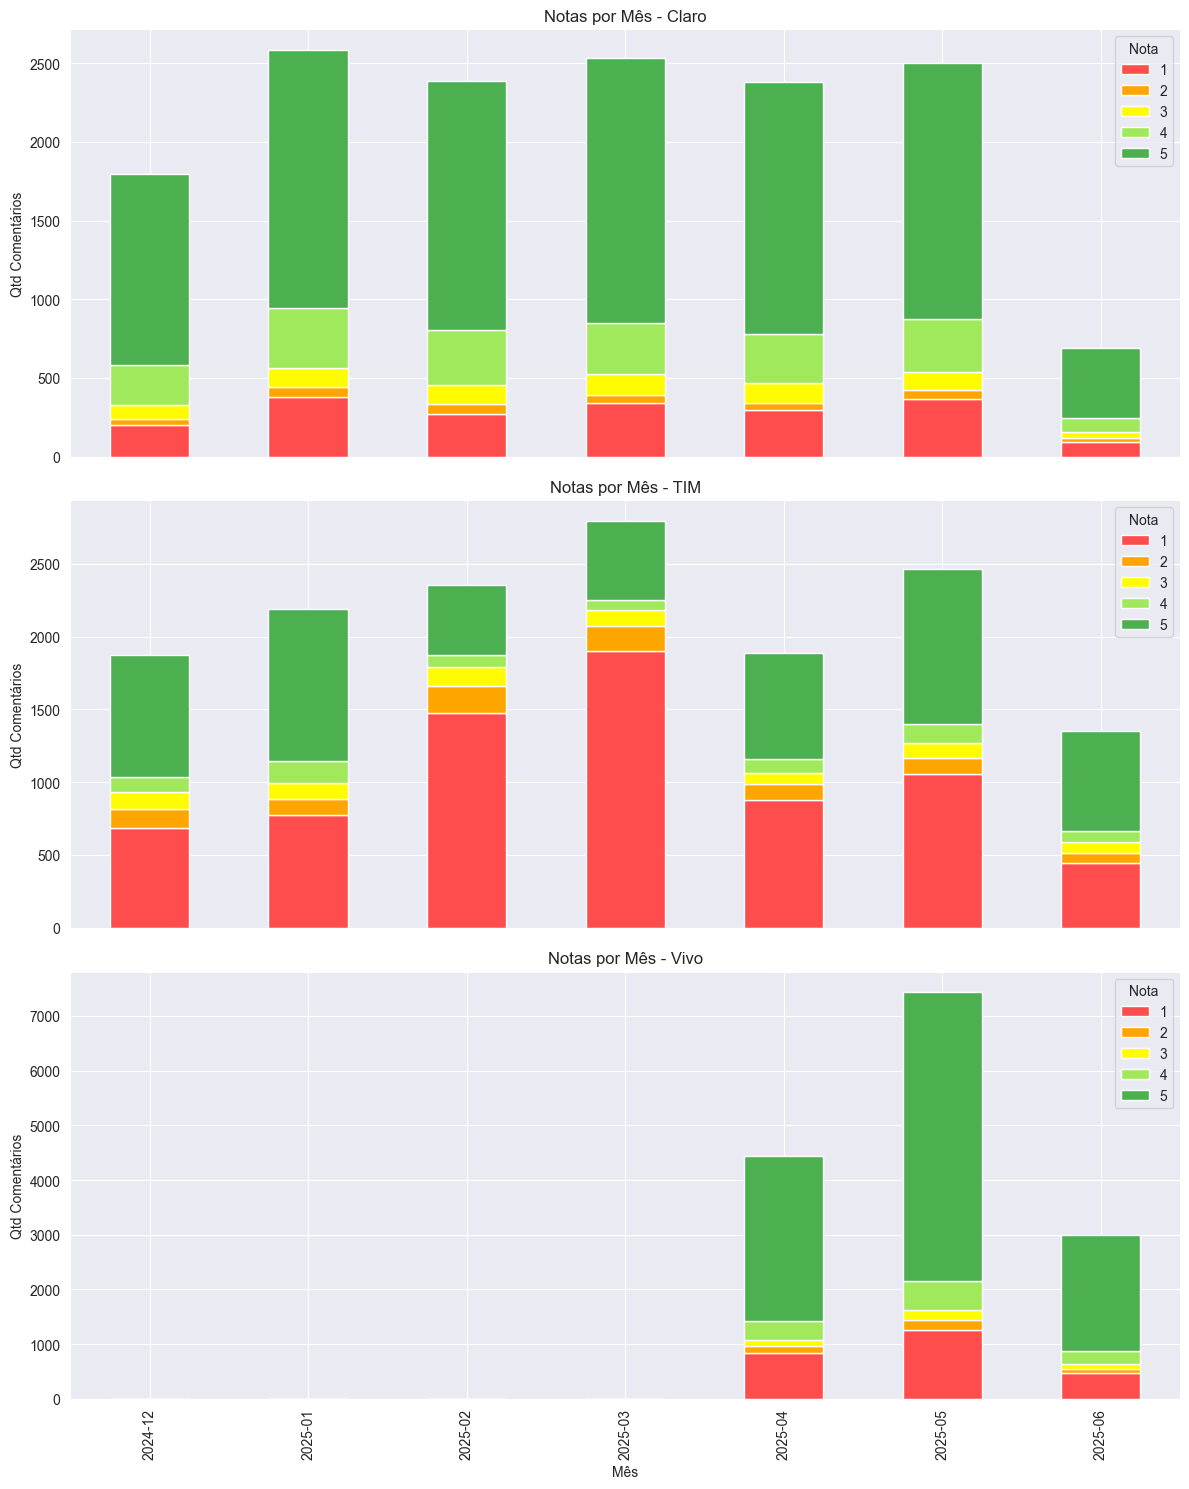

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['mes'] = df['date'].dt.to_period('M').astype(str)
todos_meses = sorted(df['mes'].unique())

cores = {1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'}
apps = df['app'].unique()
n_apps = len(apps)

fig, axes = plt.subplots(n_apps, 1, figsize=(12, 5 * n_apps), sharex=True)

for i, app in enumerate(apps):
    df_app = df[df['app'] == app]

    dados = df_app.groupby(['mes', 'score']).size().unstack(fill_value=0)
    dados = dados.reindex(todos_meses, fill_value=0)
    
    for score in [1, 2, 3, 4, 5]:
        if score not in dados.columns:
            dados[score] = 0
    
    dados = dados[[1, 2, 3, 4, 5]]

    ax = axes[i] if n_apps > 1 else axes
    dados.plot(
        kind='bar',
        stacked=True,
        color=[cores[n] for n in dados.columns],
        ax=ax,
        title=f"Notas por Mês - {app}"
    )
    ax.set_ylabel("Qtd Comentários")
    ax.legend(title="Nota", loc='upper right')

plt.xlabel("Mês")
plt.tight_layout()
plt.show()


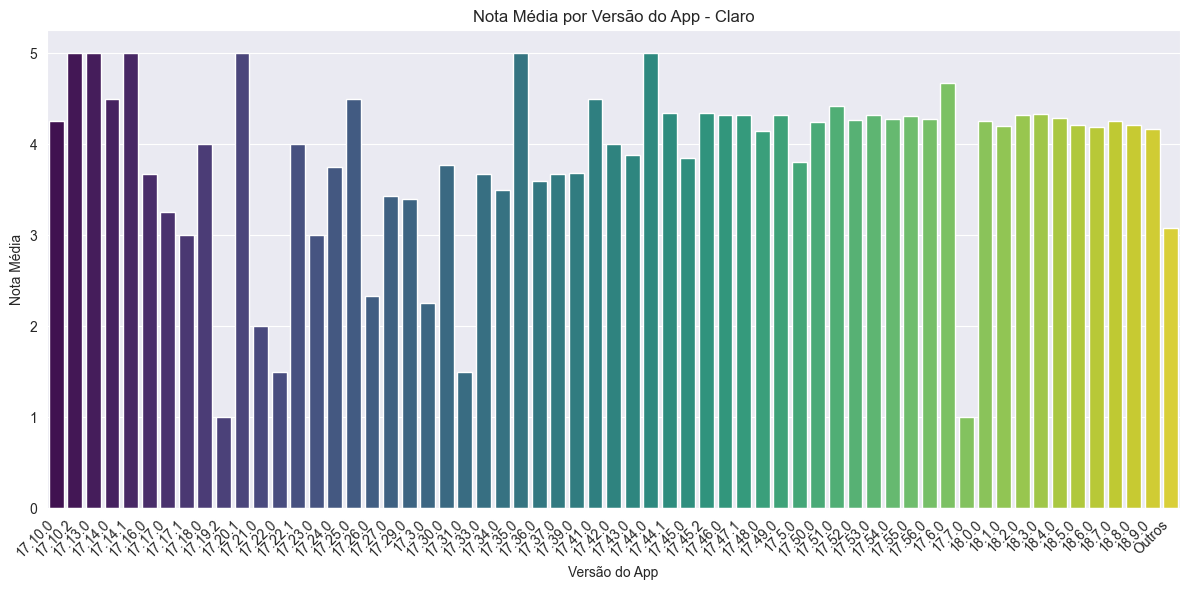

In [31]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Claro')
plt.tight_layout()
plt.show()


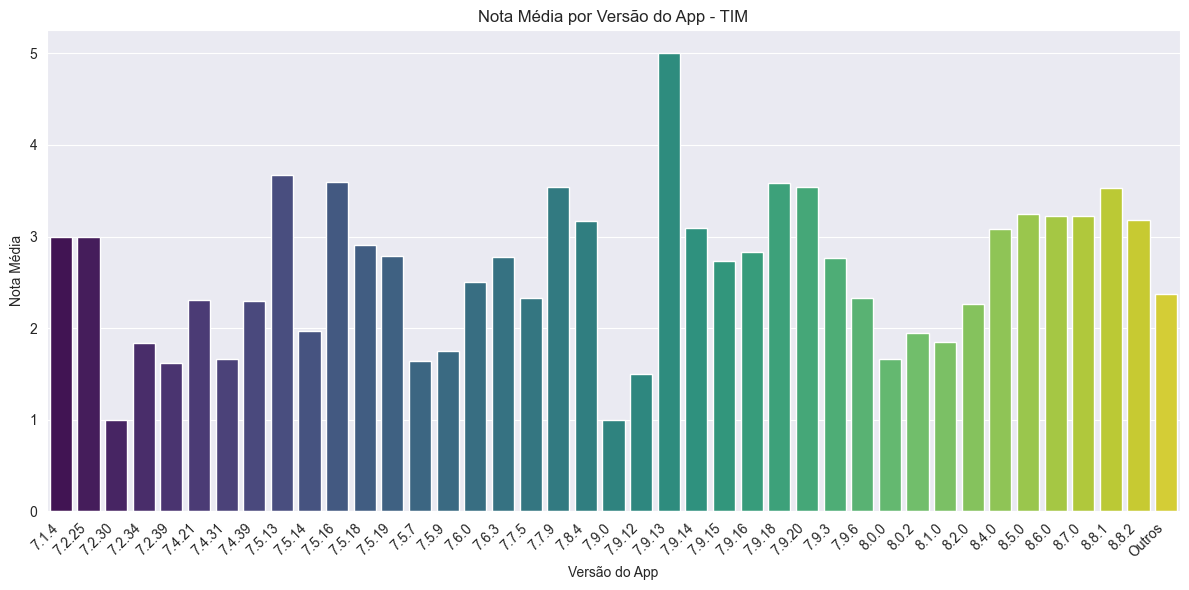

In [32]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - TIM')
plt.tight_layout()
plt.show()

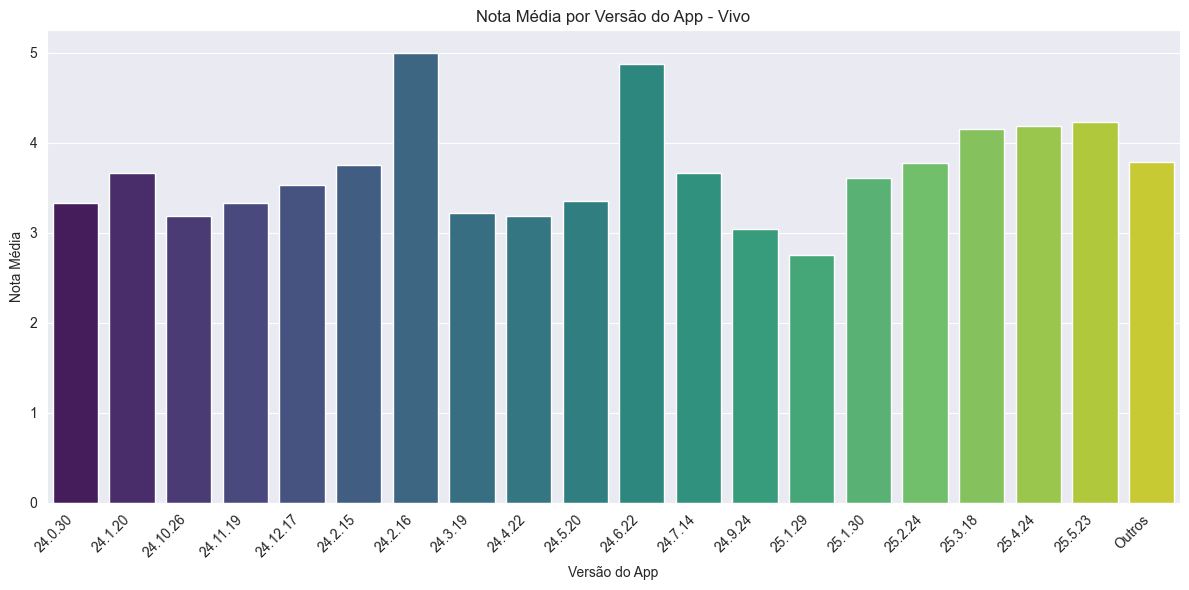

In [33]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Vivo')
plt.tight_layout()
plt.show()

### Sentimentos por Versão
- Os apps lançam muitas versão intermediárias, que dificutam uma análise mais aprofundada a partir dos comentários. Nesse caso, não foi tão relevante assim.

#### Claro

In [34]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,17.10.0,17.10.2,17.13.0,17.14.0,17.14.1,17.16.0,17.17.0,17.17.1,17.18.0,17.19.2,17.20.1,17.21.0,17.22.0,17.22.1,17.23.0,17.24.0,17.25.0,17.26.0,17.27.0,17.29.0,17.3.0,17.30.0,17.31.0,17.33.0,17.34.0,17.35.0,17.36.0,17.37.0,17.39.0,17.41.0,17.42.0,17.43.0,17.44.0,17.44.1,17.45.0,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.5.0,17.50.0,17.51.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,17.6.0,17.7.0,18.0.0,18.1.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,18.9.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,3.0,2.0,0.0,2.0,2.0,0.0,2.0,7.0,6.0,0.0,3.0,9.0,0.0,81.0,11.0,40.0,43.0,137.0,189.0,105.0,1.0,59.0,19.0,61.0,79.0,188.0,59.0,138.0,0.0,1.0,86.0,24.0,41.0,75.0,124.0,121.0,71.0,41.0,71.0,3.0,400.0
NEU,2.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,2.0,3.0,3.0,0.0,8.0,2.0,7.0,1.0,1.0,2.0,9.0,11.0,0.0,7.0,23.0,2.0,332.0,17.0,173.0,192.0,518.0,522.0,419.0,3.0,209.0,88.0,226.0,325.0,637.0,176.0,432.0,2.0,0.0,325.0,74.0,171.0,275.0,460.0,365.0,269.0,134.0,315.0,18.0,456.0
POS,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0.0,3.0,1.0,0.0,1.0,5.0,2.0,2.0,3.0,11.0,1.0,266.0,26.0,130.0,161.0,425.0,356.0,317.0,1.0,169.0,71.0,182.0,193.0,495.0,138.0,367.0,1.0,0.0,237.0,48.0,114.0,206.0,348.0,298.0,178.0,95.0,189.0,9.0,254.0


In [35]:
frequencias = df[df['app'] == 'Claro']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Claro']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,17.44.1,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.50.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,18.0.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,
NEG,81,40,43,137,189,105,59,61,79,188,59,138,86,41,75,124,121,71,41,71,167
NEU,332,173,192,518,522,419,209,226,325,637,176,432,325,171,275,460,365,269,134,315,353
POS,266,130,161,425,356,317,169,182,193,495,138,367,237,114,206,348,298,178,95,189,234


#### TIM

In [36]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,7.1.4,7.2.25,7.2.30,7.2.34,7.2.39,7.4.21,7.4.31,7.4.39,7.5.13,7.5.14,7.5.16,7.5.18,7.5.19,7.5.7,7.5.9,7.6.0,7.6.3,7.7.5,7.7.9,7.8.4,7.9.0,7.9.12,7.9.13,7.9.14,7.9.15,7.9.16,7.9.18,7.9.20,7.9.3,7.9.6,8.0.0,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,8.8.2,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,4.0,2.0,1.0,6.0,2.0,5.0,15.0,17.0,1.0,19.0,2.0,9.0,11.0,6.0,35.0,13.0,6.0,3.0,3.0,7.0,0.0,0.0,0.0,3.0,31.0,277.0,312.0,508.0,46.0,2.0,4.0,1127.0,559.0,955.0,310.0,196.0,490.0,294.0,91.0,5.0,1277.0
NEU,3.0,1.0,0.0,6.0,5.0,6.0,5.0,6.0,3.0,13.0,1.0,9.0,12.0,3.0,12.0,6.0,12.0,1.0,6.0,13.0,1.0,2.0,0.0,5.0,31.0,316.0,501.0,784.0,40.0,0.0,2.0,512.0,250.0,641.0,281.0,224.0,681.0,332.0,186.0,5.0,898.0
POS,3.0,1.0,0.0,0.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,3.0,4.0,2.0,4.0,3.0,3.0,2.0,2.0,4.0,0.0,0.0,1.0,3.0,14.0,104.0,279.0,436.0,19.0,1.0,0.0,147.0,60.0,174.0,158.0,102.0,323.0,203.0,66.0,1.0,316.0


In [37]:
frequencias = df[df['app'] == 'TIM']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'TIM']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,7.9.16,7.9.18,7.9.20,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,Outros
sentiment_output,,,,,,,,,,,,
NEG,277,312,508,1127,559,955,310,196,490,294,91,433
NEU,316,501,784,512,250,641,281,224,681,332,186,317
POS,104,279,436,147,60,174,158,102,323,203,66,128


#### Vivo

In [38]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,24.0.30,24.1.20,24.10.26,24.11.19,24.12.17,24.2.15,24.2.16,24.3.19,24.4.22,24.5.20,24.6.22,24.7.14,24.9.24,25.1.29,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,
NEG,1.0,1.0,8.0,12.0,10.0,0.0,0.0,2.0,1.0,4.0,0.0,6.0,11.0,1.0,28.0,44.0,792.0,550.0,538.0,486.0
NEU,4.0,2.0,8.0,15.0,19.0,1.0,1.0,6.0,5.0,7.0,6.0,7.0,10.0,3.0,55.0,83.0,2483.0,1916.0,1985.0,999.0
POS,1.0,0.0,0.0,4.0,7.0,3.0,1.0,1.0,4.0,3.0,1.0,2.0,6.0,0.0,25.0,54.0,1516.0,1225.0,1317.0,587.0


In [39]:
frequencias = df[df['app'] == 'Vivo']['app_version'].value_counts()

limiar = 50
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Vivo']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,
NEG,28,44,792,550,538,116
NEU,55,83,2483,1916,1985,159
POS,25,54,1516,1225,1317,74


### Sentimentos

Nesse primeiro gráfico, apenas substitui o nome original para um nome mais visível

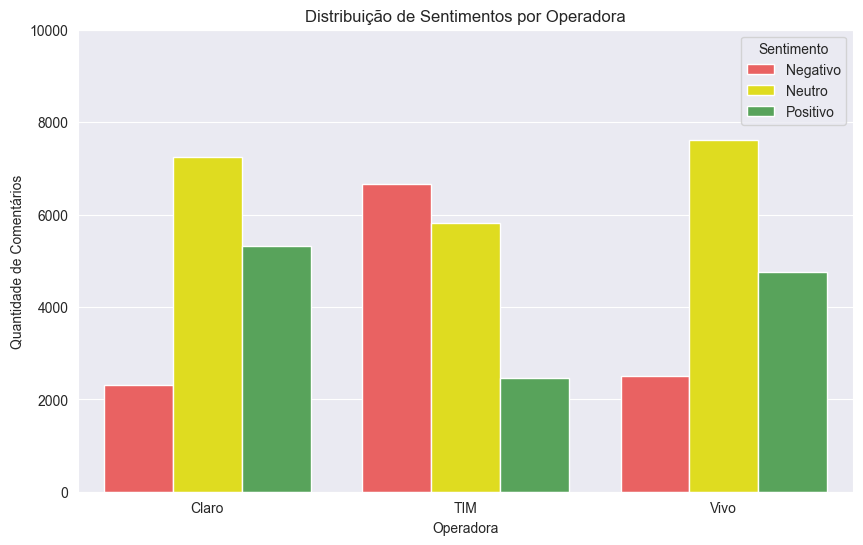

In [76]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()


Também investiguei os comentários comentados como **Neutros**, pela sua alta quantidade, encontrei diversos comentários compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos. \

Nesse caso, além do tratamento do nome, realizei um teste para manter apenas como neutros apenas os comentários que tinha a probabilidade acima 70% de serem neutros. Os comentários que eram netruos e abaixo de 70%, foram reclassificados com o segundo sentimento mais provável, positivo ou negativo.
Após essa reclassificação, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.


In [80]:
#Exemplo de alguns comentarios classificados como neutros e que poderiam estar em outra classificação
df[(df["sentiment_output"] == "NEU") & (df["sentiment_NEU"] < 0.5)][['content', 'content_proc', 'sentiment_output']].head()

,content,content_proc,sentiment_output
107,🤬,rostocomsímbolosnabo,NEU
139,gostei,gostar,NEU
276,"ia fechar um plano pós, vendedora atendeu mal ...",fechar plano pós vendedor atender mal desistir...,NEU
330,estou gostando,gostar,NEU
332,Anúncios demais,anúncio demais,NEU


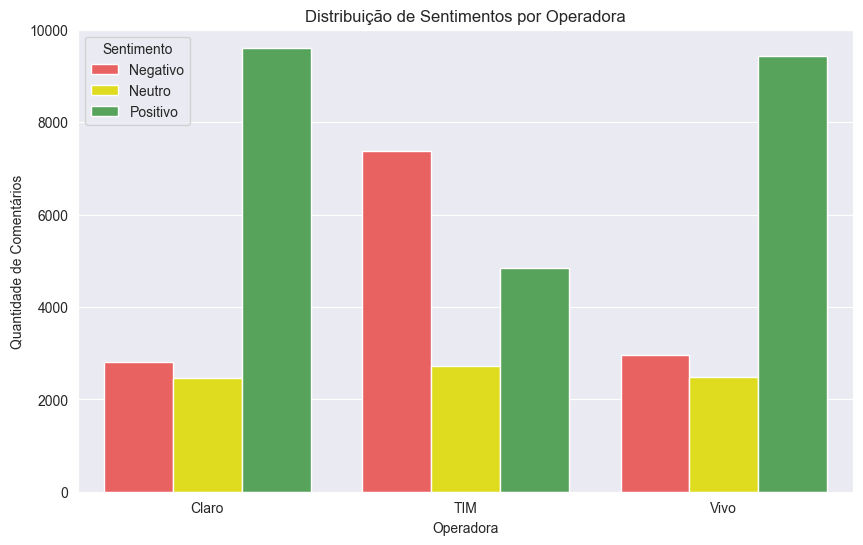

In [77]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

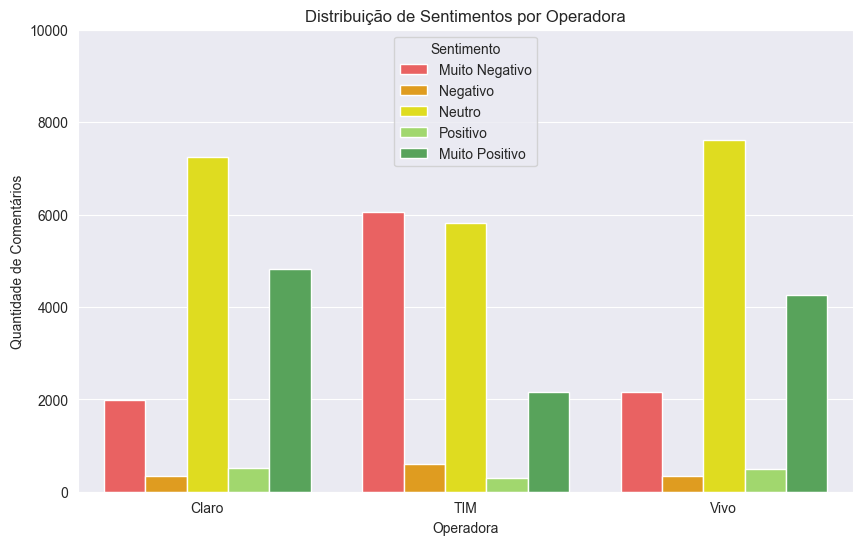

In [8]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

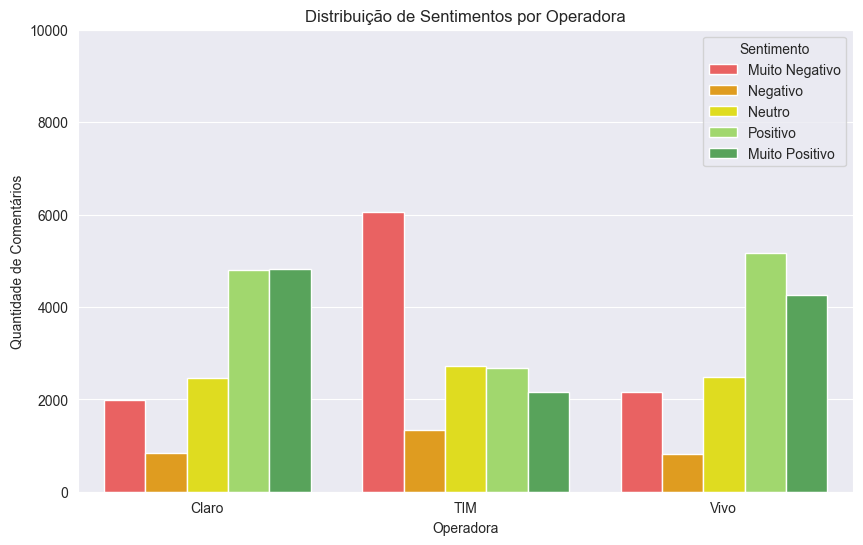

In [6]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

In [11]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gráfico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='purple'),
    opacity=0.7
), row=1, col=1)

# Gráfico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=2)

# Gráfico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='red'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribuição de Emoções por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos títulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()

---
# Classificação de Temas
Nessa seção, o objetivo principal é classificar os principais temas comentados, de maneira manual, e entender o sentimento médio sobre os temas. Aproveitando a aplicação dos modelos de sentimentos e emoções aos comentários, com suas probabilidades.

**Insights** \
Numa visão consolidada, as três operadoras tiveram um desempenho semelhante nos temas classificados. As três não tiveram sentimentos positivos em nenhum tema, apenas sentimentos que tendem a serem negativos. \

**Claro** \
Entre os 10 temas catalogados, **Operadora** e **App** tiveram um sentimento neutro, **Plano**, **Internet**, **Atendimento** e **Conta** foram um pouco negativo, e **Usuabilidade**, **Login**, **Desempenho** e **Notificações** foram negativos.
- Quando buscam atendimento via aplicativo, usuários têm dificuldades para se manter no chat ou ter retorno de solicitações abertas.
- Relacionado com o atendimento, usuários comentaram sobre faturas que já foram pagas sendo cobradas novamente ou que não aparece a fatura para pagar.
- Existe sentimentos mistos relacionados a recargas e a velocidade da internet.
- Usuários reportam muitos erros ao tentar logar no app, com tentativa de login manual ou reconhecimento de chip.
- Usuários apotam sobre o uso alto de propagandas feitas dentro do app, sms e outras formas que incomodam no dia a dia. Alguns apontam que chega afetar o desempenho do app com a publicidade apresentada.

**TIM** \
A TIM tem um comportamento distinto da Claro, os 10 temas ficaram como negativos e tiveram muitos comentários sobre **Operadora** e **App**.
- Os usuários da TIM apontam problemas estruturais do app em diversas áreas, em internet, erros, login, benefícios e etc. Parece o caso de erros nas versões mais recentes que precisam de correções imediatas.
- Como os sentimentos são mais negativos no geral, esses problemas acabam generalizando para todos os temas classificados.

**Vivo** \
A Vivo tem um comporamento semelhante com a Claro com as categorias sobre **Operadora** e **App**, sendo os temas com sentimentos mais medianos entre os 10 classificados. Também se reflete nos demais temas, com **Plano**, **Internet**, **Atendimento** e **Conta** com sentimentos um pouco negativos, e **Usuabilidade**, **Login**, **Desempenho** e **Notificações** com sentimento negativos.
- Os problemas apontados são bastante semelhantes aos apontados para o app da Claro e da TIM.

## Aplicações gerais
Na célula abaixo é removido os poucos comentários que não foiram possíveis serem trados e ficaram vazios \
Aplicação da classificação manual dos temas, buscando nos comentários as palavras selecionadas e agrupando em temas gerais \
E o cálculo por linha, utilizando as probabilidades de sentimento, para verificar um sentimento médio.

In [53]:
df.dropna(subset="content_proc", inplace=True)

df['tema_manual'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais))

df_explodido = df.explode('tema_manual').dropna(subset=['tema_manual'])

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

Pandas Apply: 100%|██████████| 44671/44671 [00:02<00:00, 18384.03it/s]


**Gráfico Operadoras**

In [ ]:
df['tema_manual_abreviado'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais_abrevidado))
df_explodido_geral = df.explode('tema_manual_abreviado').dropna(subset=['tema_manual_abreviado'])

df_explodido_geral['sentimento_continuo'] = (
    df_explodido_geral['sentiment_POS'] * 1 +
    df_explodido_geral['sentiment_NEU'] * 0 +
    df_explodido_geral['sentiment_NEG'] * -1
)

#Agrupamento por tema
df_tema = df_explodido_geral.groupby(['app', 'tema_manual_abreviado']).agg(
    volume=('tema_manual_abreviado', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

In [ ]:
fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    symbol='app',
    text="tema_manual_abreviado",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 5000],
    title="<b>Temas + Falados - Operadoras</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    },
    legend_title_text='Operadora',
    legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.835,
        xanchor="center",
        x=0.075,
        font=dict(size=12))
)

fig.show()

In [ ]:
fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    symbol='app',
    text="tema_manual_abreviado",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-0.8, 0.2],
    range_x=[-200, 2400],
    title="<b>Temas + Falados - Operadoras</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    },
    legend_title_text='Operadora',
    legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.835,
        xanchor="center",
        x=0.075,
        font=dict(size=12))
)

fig.show()

## Claro

In [26]:
df_claro = df_explodido[df_explodido["app"] == "Claro"]

#Agrupamento por tema
df_tema = df_claro.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - Claro</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [42]:
#Sentimento Negativo
operadora = df["app"]=="Claro"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

,content,sentiment_NEG
15,"A atualização estou dazerdo agora não vou opinar. mas os serviços da Claro foram nota zero, de claro não tem nada.",0.967428
21,não tô conseguindo acessar o app tá dando erro,0.837974
37,"ruim, apresenta erro direto...",0.980942
53,"inadmissível o serviço da Claro péssimo. a light retira um poste e causa a ruptura do meu serviço de internet e tv a cabo , e já são uma semana , a cada dia dão. parecer diferente , não dão a opção de um técnico para vir resolver o problema. dizem que está resolvendo e é enganoso a informação. pois já vai para uma semana . essa empresa não cumpre com sua palavra . uma vergonha. a Net era muito melhor que a claro não",0.989120
91,"Claro -Bauru sp perturbando com ligações indesejadas. Burlando o sistema do ""não me pertuebe "" Internet lenta, rápida só no consumo . YouTube consumindo toda Internet. Prezão YouTube 3Gb, somente para ""devorar"" sua Internet. A operadora claro continua devorando Internet dos clientes através desse YouTube 3gb. Claro papa internet",0.900400
105,"Experiência muito ruim, é muito lento o meu wi -fi . No aplicativo aparece tudo bem, mas continua travando e o pior , para solicitar o técnico, preciso pagar .",0.975513
106,"O APP está travando na tela da promoção impedindo que consiga fazer a recarga. Já atualizei, reinstalei e contínua dando este erro.",0.853088
142,"Aplicativo lento e ultrapassado, mas o pior é a postura da operadora que envia mensagem que irá cortar linha sendo que fatura está paga, inclusive com tal informação já no aplicativo. A postura inaceitável me levou a fazer portabilidade para a TIM.",0.987966
161,"o app está bugando, está horrível, coloco login e senha e fica girando e não sai disso, não consigo ter acesso ao app. péssimo",0.988710
166,"Serviço horrível e app pior ainda, cada vez mais lento e ineficaz.",0.993584


In [43]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

,content,sentiment_POS
648,"o aplicativo e ótimo,não trava e super ágil e facil de usar",0.988951
681,Excelente aplicativo. Melhorando a cada atualização.,0.992432
1183,muito bom o aplicativo resolve meus problemas.,0.839797
1382,o aplicativo é incrível mas as vezes ocorre um tipo de instabilidade para acessar automaticamente com a rede da Claro mas tirando isso é incrível você consegue saber tudo da sua linha e acompanhar o consumo.,0.965163
1471,perfeito para o Meu Uso sem Problemas Celular Wi-Fi TV.,0.989365
1513,excelente;o app é muito rápido e a solução de qualquer problema é resolvido de imediato .,0.989202
1806,ótimo aplicativo mais toda vez que vou pagar a fatura pede cartão de crédito eu sempre pago via Pix e outro problema não está aparecendo a opção de fatura para pagar a claro é uma excelente operadora mais vê se resolve esses problemas,0.946404
2019,ótimo serviço mas travou não consegui atualizar número de celular novo em uma opção do App .,0.916730
2023,"O app é ótimo,faço meus pagamentos todo mês sem ter nenhum ripo de problema",0.969830
2380,cancelei uma visita técnica sem problemas e bem rapido. inesperadamente chegaram visitas em minha casa e precisava dar atenção. parabéns pela agilidade do serviço claronet. me surpreendeu.,0.947605


## TIM

In [15]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 5000],
    title="<b>Temas + Falados - TIM</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [18]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - TIM (s/ Operadora, App e Desempenho)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [49]:
#Sentimento Negativo
operadora = df["app"]=="TIM"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Atendimento" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

,content,sentiment_NEG
15001,empresa péssima em relação ao atendimento,0.991633
15017,Quer mudar o plano da OI Fixo para portabilidade TIM fuxo e não consigo falar com ninguém. O atendimento digital é irritante.,0.987004
15040,"A operadora de plano mais caro que já vi. Já tentei cancelar meu plano e não consigo . Oferecem um plano caro, com dados móveis que praticamente não pegam em lugar nenhum. E o atendimento pela operadora é péssimo e ainda deixa a gente sem resposta e sem solução para o problema",0.984908
15094,"Péssimo. Fiz a portabilidade da Claro para Tim a 2 meses e até agora não consegui usar, fechei um plano para usar benefícios e nada. Via telefone não consigo atendimento e já tenho 3 protocolos da loja.",0.976924
15185,péssimo atendimento horrível,0.993200
15248,"Meu plano era 80gb, baixaram em menos de 1 ano para 76gb e agora mudaram meu plano para 15gb. Aumentaram o valor do plano em menos de 1 ano, você não pode mandar áudio, nem imagem comprovando, atendente humana não aparece, desligam na sua cara... Eu tou passando mal aqui... DESCASO TOTAL com o cliente, quero cancelar wifi e 4g dessa operadora diabólica 😡... NÃO ENTREM É FURADA!",0.959955
15263,"Pior operadora, só uso porque a única que pega na região em que moro hje. SINAL horrível, atendimento péssimo.",0.992129
15361,"se tornou o pior atendimento de todos uma grande vergonha péssima operadora, quando renova a internet o sinal some , trinta dias de uso nunca chegou quando da a data de vencimento a internet vai embora junto vergonhoso.",0.992178
15412,"pra ficar ruim tem que melhorar muito. trava toda hora, diz que tem uma atualização mais quando tento atualizar volta pra página inicial. Quando abre sempre diz que estou sem saldo. E uma observação, no atendimento por telefone*144 o atendimento é pior ainda. Não tem opção de falar com o atendente. Como falei no começo, para ficar ruim tem que melhorar muito, infelizmente.",0.964840
15421,péssimo app difícil atendimento,0.991736


In [48]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Atendimento" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

,content,sentiment_POS
15002,quase o melhor atendimento falta só menos anúncios,0.953299
15020,Bom serviço de atendimento,0.981695
15089,bom atendimento,0.969055
15368,Atendimento ímpar.,0.990155
15921,Bom atendimento muito bom 👍,0.939548
16175,Nada a reclamar. A Tim tem me dado bastante benefícios. Atendimento rápido e eficaz! App eficaz.,0.979279
16294,Gostei muito do atendimento.,0.978974
16321,ótima o atendimento obrigado,0.982661
16562,o atendimento pessoal é bom,0.986668
16747,"Gostei bastante,mas o atendimento ao cliente é demorado para falar com um dos atende dentes.",0.806056


## Vivo

In [21]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 3000],
    title="<b>Temas + Falados - Vivo</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [22]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necessário

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - Vivo (s/ App)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [54]:
#Sentimento Negativo
operadora = df["app"]=="Vivo"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

,content,sentiment_NEG
30055,péssima. o app é lento e confuso é repetitivo,0.992501
30101,"não consigo acessar o app de jeito nenhum pra pagar minha fatura ,estou tentando entrar no app e só dá erro ,coloco meu CPF nada ,meu celular nada ,tá horrível",0.977096
30108,"Aplicativo sempre falha e os itens inacessíveis, nem o saldo consigo consultar e esses problemas acontecem há mais de 3 anos. APP atualizado como praxe, assim como a resposta genérica de retorno.",0.912551
30242,"essa aplicativo está horrível!! as abas ficam demorando a carregar e nem Internet está enviando mais, só fica dando: algo deu errado, tente novamente ou volte para o início. aí alguém pode dizer, é seu wifi que está ruim. bom, se eu dentro de casa com o sinal completo do wifi foi o problema, então pq quando eu liguei os dados móveis (INTERNET DELES) que aparentemente estava funcionando deu a mesma coisa!? 🤔 esse app está péssimo. na verdade, essa operadora com fama ladrona em si!",0.983585
30262,"trava toda vez que entra, sem conseguir acessar o serviço.",0.813425
30296,o app tá bugando na hora de enviar internet marca que o saldo da gente tá vazio,0.925603
30315,Hoje 08/06/2025 qualidade imagem ruim. O aplicativo é uma piada não ajuda no atendimento. Lamentável o serviço é aplicativo. Instável o sinal de Internet e TV. Sempre que há uma ação da Ability no condomínio acontece. Hoje 23/05 sem sinal e Internet. No aplicativo só dá erro inesperado. Lamentável ser cliente vivo.,0.988179
30334,Esse aplicativo É HORRÍVEL!!! Não funciona e trava toda hora!,0.991571
30381,"Não consigo alterar o endereço pelo aplicativo, sempre dá erro. Irritante isso.",0.987904
30388,aplicativo toda hora aparece um.erro,0.896050


In [55]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

,content,sentiment_POS
30157,"Agora sim, a análise remota de problemas da Vivo consertou tudo! Ficou uma beleza... 👏",0.860003
30662,"Ótimo, nunca tive problemas! Faço tudo pelo app é super fácil.",0.894991
31826,"Não tenho o que questionar, nunca tive problemas.""Parabéns pelo excelente aplicativo! É uma ferramenta incrível e muito útil!",0.988535
32137,muito bom pode resolver todos os problemas ok obrigado,0.953129
32750,bem legal o aplicativo não tenho nenhum problema em relação ao uso apenas gostaria que que a Vivo disponibilizasse Internet liberada para jogos seria bem legal.....as vezes acaba muito rápido ..Só uma dica seria legal....valeu 😌👋,0.977024
33429,excelente trabalho nenhum problema,0.982819
34129,Quero registrar meus parabéns pelo atendende de hoje 27/05/2025...exelente atendimento e resolveu meu problema que a anos não era resolvido...PARABÉNS!!!,0.991294
34242,"o app era ótimo, conseguia editar senha e ver quem está conectado a minha rede, mas com a atualização de hoje tiraram essa função e passaram essas funções para o smart wifi, que simplesmente não funciona, pois agora não consigo desbloquear dispositivos quando quero, sendo assim, irei cancelar minha assinatura vivo",0.885241
34553,"Adoro usar o app da Vivo, apesar das instabilidade da Internet de vez enquanto. Gostaria de deixar uma sugestão, consigo fazer quase tudo pelo app, gostaria de fazer transferência de crédito tbm pelo app, até pq o 7000, na maioria das vezes não funciona, e se esse serviço pudesse ser feito pelo app tbm seria maravilhoso. #fica a dica",0.959931
34874,"excelente aplicativo 🤩 não tenho problemas com a vivo,,,, parabéns continue assim",0.990668
